<a href="https://colab.research.google.com/github/SalvatoreAdalberto/mlapp/blob/main/7_TAD_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 7: Time-series Anomaly Detection



Pandas was updated on 03/04/2023 to version 2.0, which is not compatibile with tsfel. Dowgrade to 1.5.3

In [1]:
!pip install pandas==1.5.3
!pip install tsfel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.9 MB/s eta 0:00:00


## Import and settings

In [2]:
!pip install keras_tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 4.4 MB/s eta 0:00:00


In [8]:
import os
import time
import tsfel
import warnings
import datetime
import keras_tuner
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.cm as cm
from sklearn import metrics
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn import preprocessing
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import VarianceThreshold

from google.colab import drive
drive.mount('/content/drive')

# Set style for matplotlib
plt.style.use("Solarize_Light2")

Mounted at /content/drive


In [17]:

ROOTDIR_DATASET_NORMAL = "/content/drive/MyDrive/KukaV1/normal"

## Utils

In [10]:
def seaborn_cm(cm, ax, tick_labels, fontsize=14, title=None, sum_actual="over_columns",
               xrotation=0, yrotation=0):
    """
    Function to plot a confusion matrix
    """
    from matplotlib import cm as plt_cmap
    group_counts = ["{:0.0f}".format(value) for value in cm.flatten()]
    if sum_actual == "over_columns":
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    elif sum_actual == "over_rows":
        cm = cm.astype('float') / cm.sum(axis=0)[:, np.newaxis]
    else:
        print("sum_actual must be over_columns or over_rows")
        exit()
    cm = np.nan_to_num(cm)
    mean_acc = np.mean(np.diag(cm)[cm.sum(axis=1) != 0])
    std_acc = np.std(np.diag(cm))
    group_percentages = ["{:0.0f}".format(value*100) for value in cm.flatten()]
    cm_labels = [f"{c}\n{p}%" for c, p in zip(group_counts, group_percentages)]
    cm_labels = np.asarray(cm_labels).reshape(len(tick_labels), len(tick_labels))
    sns.heatmap(cm,
                ax=ax,
                annot=cm_labels,
                fmt='',
                cbar=False,
                cmap=plt_cmap.Greys,
                linewidths=1, linecolor='black',
                annot_kws={"fontsize": fontsize},
                xticklabels=tick_labels,
                yticklabels=tick_labels)
    ax.set_yticklabels(ax.get_yticklabels(), size=fontsize, rotation=yrotation)
    ax.set_xticklabels(ax.get_xticklabels(), size=fontsize, rotation=xrotation)
    if title:
        title = f"{title}\nMean accuracy {mean_acc * 100:.1f} +- {std_acc * 100:.1f}"
    else:
        title = f"Mean accuracy {mean_acc * 100:.1f} +- {std_acc * 100:.1f}"
    ax.set_title(title)
    if sum_actual == "over_columns":
        ax.set_ylabel("Actual")
        ax.set_xlabel("Predicted")
    else:
        ax.set_ylabel("Predicted")
        ax.set_xlabel("Actual")
    ax.axis("off")

# Introduction

You will use the dataset provided in the first Lab, concerning time series.

In such Lab1, we built a model able to classify the action that is performing a Kuka robot.

Now, we will explore Time Series Anomaly Detection (TAD), hence considering also the data contained in the collinsion foder.

This function loads sensor readings and the correspondig metadata. 
The output is a dataframe grouped by action.

In [11]:
def get_df_action(filepaths_csv, filepaths_meta, action2int=None, delimiter=";"):
    # Load dataframes
    print("Loading data.")
    # Make dataframes
    # Some classes show the output boolean parameter as True rather than true. Fix here
    dfs_meta = list()
    for filepath in filepaths_meta:
        df_m = pd.read_csv(filepath, sep=delimiter)
        df_m.str_repr = df_m.str_repr.str.replace('True', 'true')
        df_m['filepath'] = filepath
        dfs_meta.append(df_m)

    df_meta = pd.concat(dfs_meta)
    df_meta.index = pd.to_datetime(df_meta.init_timestamp.astype('datetime64[ms]'), format="%Y-%m-%dT%H:%M:%S.%f")
    df_meta['completed_timestamp'] = pd.to_datetime(df_meta.completed_timestamp.astype('datetime64[ms]'),
                                                    format="%Y-%m-%dT%H:%M:%S.%f")
    df_meta['init_timestamp'] = pd.to_datetime(df_meta.init_timestamp.astype('datetime64[ms]'),
                                               format="%Y-%m-%dT%H:%M:%S.%f")

    # Eventually reduce number of classes
    # df_meta['str_repr'] = df_meta.str_repr.str.split('=', expand = True,n=1)[0]
    # df_meta['str_repr'] = df_meta.str_repr.str.split('(', expand=True, n=1)[0]

    actions = df_meta.str_repr.unique()
    dfs = [pd.read_csv(filepath_csv, sep=";") for filepath_csv in filepaths_csv]
    df = pd.concat(dfs)

    # Sort columns by name !!!
    df = df.sort_index(axis=1)

    # Set timestamp as index
    df.index = pd.to_datetime(df.time.astype('datetime64[ms]'), format="%Y-%m-%dT%H:%M:%S.%f")
    # Drop useless columns
    columns_to_drop = [column for column in df.columns if "Abb" in column or "Temperature" in column]
    df.drop(["machine_nameKuka Robot_export_active_energy",
             "machine_nameKuka Robot_import_reactive_energy"] + columns_to_drop, axis=1, inplace=True)
    signals = df.columns

    df_action = list()
    for action in actions:
        for index, row in df_meta[df_meta.str_repr == action].iterrows():
            start = row['init_timestamp']
            end = row['completed_timestamp']
            df_tmp = df.loc[start: end].copy()
            df_tmp['action'] = action
            # Duration as string (so is not considered a feature)
            df_tmp['duration'] = str((row['completed_timestamp'] - row['init_timestamp']).total_seconds())
            df_action.append(df_tmp)
    df_action = pd.concat(df_action, ignore_index=True)
    df_action.index = pd.to_datetime(df_action.time.astype('datetime64[ms]'), format="%Y-%m-%dT%H:%M:%S.%f")
    df_action = df_action[~df_action.index.duplicated(keep='first')]

    # Drop NaN
    df = df.dropna(axis=0)
    df_action = df_action.dropna(axis=0)

    if action2int is None:
        action2int = dict()
        j = 1
        for label in df_action.action.unique():
            action2int[label] = j
            j += 1

    df_merged = df.merge(df_action[['action']], left_index=True, right_index=True, how="left")
    # print(f"df_merged len: {len(df_merged)}")
    # Where df_merged in NaN Kuka is in idle state
    df_idle = df_merged[df_merged['action'].isna()].copy()
    df_idle['action'] = 'idle'
    df_idle['duration'] = df_action.duration.values.astype(float).mean().astype(str)
    df_action = pd.concat([df_action, df_idle])

    # ile label must be 0 for debug mode
    action2int['idle'] = 0
    print(f"Found {len(set(df_action['action']))} different actions.")
    print("Loading data done.\n")

    return df_action, df, df_meta, action2int

Load all data (and metadata) for frequency = 10 Hz for the normal time series

In [15]:
!ls {ROOTDIR_DATASET_NORMAL}

ls: cannot access '/content/drive/MyDrive/Kuka_v1/normal': No such file or directory


In [18]:
filepath_csv = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_0.1s.csv") for r in [0, 2, 3, 4]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_0.1s.metadata") for r in [0, 2, 3, 4]]
df_action, df, df_meta, action2int = get_df_action(filepath_csv, filepath_meta)

Loading data.
Found 31 different actions.
Loading data done.



In [19]:
df_action.head(2)

,machine_nameKuka Robot_apparent_power,machine_nameKuka Robot_current,machine_nameKuka Robot_export_reactive_energy,machine_nameKuka Robot_frequency,machine_nameKuka Robot_import_active_energy,machine_nameKuka Robot_phase_angle,machine_nameKuka Robot_power,machine_nameKuka Robot_power_factor,machine_nameKuka Robot_reactive_power,machine_nameKuka Robot_voltage,...,sensor_id5_AccZ,sensor_id5_AngX,sensor_id5_AngY,sensor_id5_AngZ,sensor_id5_GyroX,sensor_id5_GyroY,sensor_id5_GyroZ,time,action,duration
time,,,,,,,,,,,,,,,,,,,,,
2022-08-11 13:09:50.319,165.617218,0.976074,1383.394043,49.951218,1618.833008,319.896576,126.683266,0.764916,-106.669258,228.842468,...,309.87,248.15,350.14,328.11,0.0,0.0,0.0,2022-08-11T13:09:50.319094+00:00,"pickFromPallet(2,2)=[true,1,0]",12.052
2022-08-11 13:09:50.419,165.617218,0.976074,1383.394043,49.951218,1618.833008,319.896576,126.683266,0.764916,-106.669258,228.842468,...,309.88,248.15,350.14,328.11,0.0,0.0,0.0,2022-08-11T13:09:50.419094+00:00,"pickFromPallet(2,2)=[true,1,0]",12.052


# Features extraction

We will leverage [Time Series Feature Extraction Library (TSFEL)](https://tsfel.readthedocs.io/en/latest/), to extract features from time series data. 

In [20]:
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

def get_features_ts(domain, df_action, df_meta, frequency, action2int):
    duration_dict = {1: 10, 10: 1, 100: 0.1, 200: 0.05}
    duration_min = duration_dict[int(frequency)]
    cfg = tsfel.get_features_by_domain(domain)
    dataframe_features = list()
    print("Computing features.")
    # Idle does not have associated timestamps. Window is set to 10 seconds
    df_by_action = df_action[df_action["action"] == "idle"].copy()
    X = tsfel.time_series_features_extractor(cfg,
                                             df_by_action.select_dtypes(['number']),
                                             fs=frequency,
                                             header_names=df_by_action.select_dtypes(['number']).columns + '-',
                                             window_size=int(frequency * 10),
                                             verbose=False)
    time = pd.to_datetime(df_by_action.time.astype('datetime64[ms]'), format="%Y-%m-%dT%H:%M:%S.%f")
    X['start'] = [t[0] for t in
                  tsfel.utils.signal_processing.signal_window_splitter(time, window_size=int(frequency * 10))]
    X['duration'] = 10
    X['end'] = X['start'] + pd.to_timedelta(X['duration'], 's')
    X['label'] = action2int["idle"]
    X.drop('duration', inplace=True, axis=1)
    dataframe_features.append(X)
    actions = list(df_action.action.unique())
    actions.remove("idle")
    for action in actions:
        df_by_action = df_action[df_action["action"] == action].copy()
        df_meta_by_action = df_meta[df_meta['str_repr'] == action].copy()
        df_meta_by_action['start'] = pd.to_datetime(df_meta_by_action.init_timestamp.astype('datetime64[ms]'),
                                                    format="%Y-%m-%dT%H:%M:%S.%f")
        df_meta_by_action['end'] = pd.to_datetime(
            df_meta_by_action.completed_timestamp.astype('datetime64[ms]'), format="%Y-%m-%dT%H:%M:%S.%f")
        for _, row in df_meta_by_action.iterrows():
            df_by_action_by_event = df_by_action.loc[row["start"]: row["end"]]
            if len(df_by_action_by_event) < duration_min * frequency:
                print(f"Skipped feature extraction for {action} {row['start']} : {row['end']}.")
                continue

            X = tsfel.calc_window_features(cfg,
                                           df_by_action_by_event.select_dtypes(['number']),
                                           header_names=df_by_action_by_event.select_dtypes(['number']).columns + '-',
                                           fs=frequency,
                                           verbose=False)
            # print(X.shape)
            X['label'] = action2int[action]
            X['start'] = row['start']
            X['end'] = row['end']
            dataframe_features.append(X)

    dataframe_features = pd.concat(dataframe_features)
    print("Computing features done.")
    return dataframe_features

In [21]:
start_time = time.time()
df_features = get_features_ts("statistical", df_action, df_meta, 10, action2int)
print("--- %s seconds ---" % (time.time() - start_time))

Computing features.


Skipped feature extraction for pickFromPallet(1,2)=[true,1,0] 2022-08-11 14:37:37.436000 : 2022-08-11 14:37:37.421000.
Skipped feature extraction for placeToPallet(1,1)=[true,0] 2022-08-11 14:37:37.421000 : 2022-08-11 14:37:37.442000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.568000 : 2022-08-11 15:36:32.533000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.572000 : 2022-08-11 15:36:32.561000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.533000 : 2022-08-11 15:36:32.572000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.561000 : 2022-08-11 15:36:32.561000.
Computing features done.
--- 471.21521973609924 seconds ---


Prepare data for train and test

Note that:

*   the last three columns are the start, the end and the label corresponding to the action the robot is performing. Label is our gound truth, start and end can be dropped for the moment.
*   set NaN valuesto 0.




In [22]:
df_features.isnull().values.any()

True

In [23]:
df_features_nonan = df_features.fillna(0)

In [24]:
df_train, df_test = train_test_split(df_features_nonan)

In [25]:
X_train = df_train.drop(["label", "start", "end"], axis=1)
y_train = df_train["label"]
X_test = df_test.drop(["label", "start", "end"], axis=1)
y_test = df_test["label"]

In [26]:
# Normalise features
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)

# Remove zero-variance features
selector_variance = VarianceThreshold()
selector_variance.fit(X_train)
X_train = pd.DataFrame(selector_variance.transform(X_train),
                        columns=X_train.columns.values[selector_variance.get_support()])

# Remove highly correlated features
corr_features = tsfel.correlated_features(X_train,
                                          threshold=0.95)
X_train.drop(corr_features, inplace=True, axis=1)

# Lasso selector
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X_train, y_train)
lasso = SelectFromModel(lsvc, prefit=True)
selected_features = X_train.columns.values[lasso.get_support()]
X_train = X_train[selected_features].copy()

# Labels
num_classes = len(set(y_train))
y_train_categorical = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)

# Test
X_test = pd.DataFrame(selector_variance.transform(scaler.transform(X_test)),
                      columns=X_test.columns.values[selector_variance.get_support()])
X_test.drop(corr_features, inplace=True, axis=1)
X_test = X_test[selected_features].copy()

# Assignment #1: Train a Bayesian MLP

Here we will train a Bayesian MLP able to provide a reliable uncertainty metric.
We will use [keras tuner](https://keras.io/keras_tuner/) to tune the huperparameters of such model.

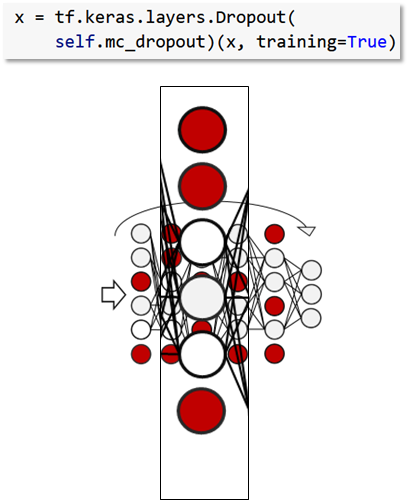

In [27]:
# Create the MLP tf model
def build_model(hp):
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4]) 
    hp_drop_rate =hp.Float('drop_rate', min_value=0.1, max_value=0.75, step=32) 
    hp_drop_rate_last = hp.Float('drop_rate', min_value=0.1, max_value=0.75, step=32) 
    inputs = tf.keras.layers.Input(shape=(X_train.values.shape[1],))
    x = inputs
    for i in range(hp.Int("mlp_layers", 1, 3)):
        x = tf.keras.layers.Dense(
           units=hp.Int(f"units_{i}", 32, 128, step=32), activation="relu",
        )(x)
        x = tf.keras.layers.Dropout(rate=hp_drop_rate)(x, training=True)
    x = tf.keras.layers.Dropout(rate=0.5)(x, training=True)
    x = tf.keras.layers.Dense(num_classes, activation='softmax', name='predictions')(x) 
    tf_model = tf.keras.Model(inputs=inputs, outputs=x) 
    tf_model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                metrics=['accuracy'])
    return  tf_model

In [29]:
DIR_OUTPUT = "/content/models"
try:
   os.makedirs(DIR_OUTPUT)
except FileExistsError: 
   print(f"{DIR_OUTPUT} exists yet.")
tuner = keras_tuner.Hyperband(
   build_model,
   overwrite=True, 
   objective='accuracy',
   max_epochs=50, 
   factor=3,
   directory=os.path.join(DIR_OUTPUT, "keras tuner"), 
   project_name="keras_tuner_prj")

stop_early = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=15) 
print("Grid search training.")
tuner.search(X_train.values, y_train_categorical, epochs=50, 
          callbacks=[stop_early,tf.keras.callbacks.TensorBoard(
             os.path.join(DIR_OUTPUT, '/tmp/tb_logs'))])

Trial 90 Complete [00h 00m 10s]
accuracy: 0.8957476019859314

Best accuracy So Far: 0.9629629850387573
Total elapsed time: 00h 04m 17s


In [30]:
classifier = tuner.get_best_models()[0]
y_test_predict = classifier.predict(X_test.values)

8/8 [==============================] - 0s 2ms/step


Check the model performance

In [31]:
cm = confusion_matrix(y_test, y_test_predict.argmax(axis=1), labels=list(action2int.values()))
fig, ax = plt.subplots(1,1, figsize=(8,8))
int2action = {v: k for k, v in action2int.items() }
seaborn_cm = (cm, ax, [int2action[l] for l in action2int.values()], fontsize=8, xrotation=90)
plt.tight_layout()

SyntaxError: ignored

Here we implement a wrapper to compute uncertainty metrics (see Lab6)

In [ ]:
class Confidence:
    [...]

PLot the distribution for correct and wrong predictiond

# Load collisions and extract features

In [ ]:
ROOTDIR_DATASET_ANOMALY = "/content/drive/MyDrive/KukaV1/collisions"

In [ ]:
!ls {ROOTDIR_DATASET_ANOMALY}

Note that we have a discrepancy between time in the lab where the data were collected and the PC which stored them. This line fix it.

In [ ]:
collisions = pd.read_excel(os.path.join(ROOTDIR_DATASET_ANOMALY, "20220811_collisions_timestamp.xlsx"))
collisions_init = collisions[collisions['Inizio/fine'] == "i"].Timestamp - pd.to_timedelta([2] * len(collisions[collisions['Inizio/fine'] == "i"].Timestamp), 'h')

In [ ]:
collisions

In [ ]:
filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_0.1s.csv") for r in [1, 5]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_0.1s.metadata") for r in [1, 5]]
df_action, df, df_meta, action2int = get_df_action(filepath_csv, filepath_meta)

In [ ]:
start_time = time.time()
df_features_collision = get_features_ts("statistical", df_action, df_meta, 10, action2int)
print("--- %s seconds ---" % (time.time() - start_time))

Preprocessing

In [ ]:
df_features_collision.isnull().values.any()

In [ ]:
df_features_collision_nonan = df_features_collision.fillna(0)

In [ ]:
X_collision = df_features_collision_nonan.drop(["label", "start", "end"], axis=1)
y_collision = df_features_collision_nonan["label"]

In [ ]:
X_collision = pd.DataFrame(selector_variance.transform(scaler.transform(X_collision)),
                           columns=X_collision.columns.values[selector_variance.get_support()])
X_collision.drop(corr_features, inplace=True, axis=1)
X_collision = X_collision[selected_features].copy()

# Assignment #2: Compute uncertainty

In [ ]:
[...]

# Assignment #3:  Assess TAD algorithm performance via ROC curves

Consider that unconfident predictions will show an uncertainty above a given threshold

In [ ]:
[...]